In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from collections import Counter
import random
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Convolutional neural network

## Load data

In [2]:
braking = np.load("extracted_data/breaking.npy")
steering =  np.load("extracted_data/steering.npy")
acceleration = np.load("extracted_data/acceleration.npy")
normal = np.load("extracted_data/normal.npy")

In [3]:
#for i in braking:
#    x,y,z = i[:,0],i[:,1],i[:,2]
#    plt.plot(x, label="x")
#    plt.plot(y, label="y")
#    plt.plot(z, label="z")
#    plt.legend()
#    plt.show()

## Build and evaluate model

In [4]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
def split_data (b ,s ,a, n):
    ## split data
    X_train_break, X_test_break, y_train_break, y_test_break = train_test_split(b, np.array([0]*150), test_size=0.3, random_state=42)
    X_train_steer, X_test_steer, y_train_steer, y_test_steer = train_test_split(s, np.array([1]*150), test_size=0.3, random_state=42)
    X_train_acc, X_test_acc, y_train_acc, y_test_acc = train_test_split(a, np.array([2]*150), test_size=0.3, random_state=42)
    X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(n, np.array([3]*148), test_size=0.3, random_state=42)
    ## combine data 
    X_combined_train = np.concatenate((X_train_break ,X_train_steer ,X_train_acc, X_train_norm), axis=0)
    Y_combined_train = np.concatenate((y_train_break ,y_train_steer ,y_train_acc, y_train_norm), axis=0)
    X_combined_test = np.concatenate((X_test_break ,X_test_steer ,X_test_acc, X_test_norm), axis=0)
    Y_combined_test = np.concatenate((y_test_break ,y_test_steer ,y_test_acc, y_test_norm), axis=0)
    ## shuffle data
    X_train, y_train = shuffle(X_combined_train, Y_combined_train)
    X_test,  y_test= shuffle(X_combined_test, Y_combined_test)
    
    return (X_train, X_test, y_train, y_test)
    

In [5]:
from keras.models import Sequential
from tensorflow.keras.layers import Conv1D,Dropout,Dense,Flatten,MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

def cnn_model (rows,columns):
    model = Sequential()
    model.add(Conv1D(64, 7,padding='valid', activation = 'relu', input_shape = (rows,columns)))
    model.add(Dropout(0.5))

    model.add(Conv1D(64, 5,padding='valid', activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(MaxPooling1D(pool_size=5))

    model.add(Flatten())

    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.5))

    model.add(Dense(4, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [6]:
def evaluate (b ,s ,a, n):
    evaluation_results = dict()
    
    for i in range(5):
        results = dict()
        X_train, X_test, y_train, y_test = split_data (b ,s ,a, n)
      
        ## model
        model = cnn_model(20,3)
        history = model.fit(X_train, y_train, epochs = 40, validation_split=0.2, verbose=0)
        results["history"] = history

        ## evaluate
        results["score"] = model.evaluate(X_test,y_test,verbose=0)
        predict = model.predict(X_test)
        classes = np.argmax(predict,axis=1)
        mat = confusion_matrix(y_test, classes)
        results["mat"] = mat

        evaluation_results[i] = results
        
    return evaluation_results,model 

In [7]:
logs,model = evaluate(braking ,steering ,acceleration, normal)

Accuracy: 0.9766666650772095


(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

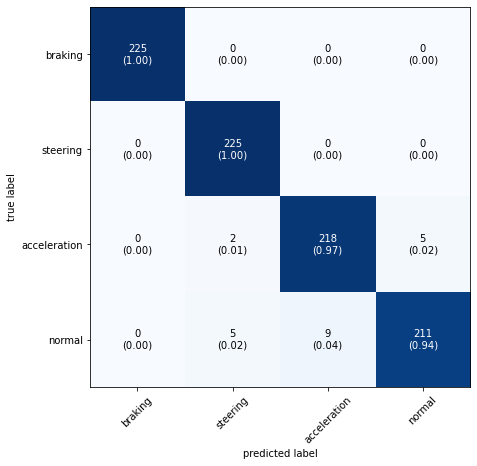

In [8]:
mat = np.zeros((4,4))
accuracy = 0
for key,value in logs.items():
    mat +=  logs[key]["mat"]
    accuracy += logs[key]["score"][1]
    
    
print("Accuracy:",accuracy/5)
    
plot_confusion_matrix(conf_mat=mat.astype(int), class_names=["braking", "steering","acceleration", "normal"], show_normed=True, figsize=(7,7))

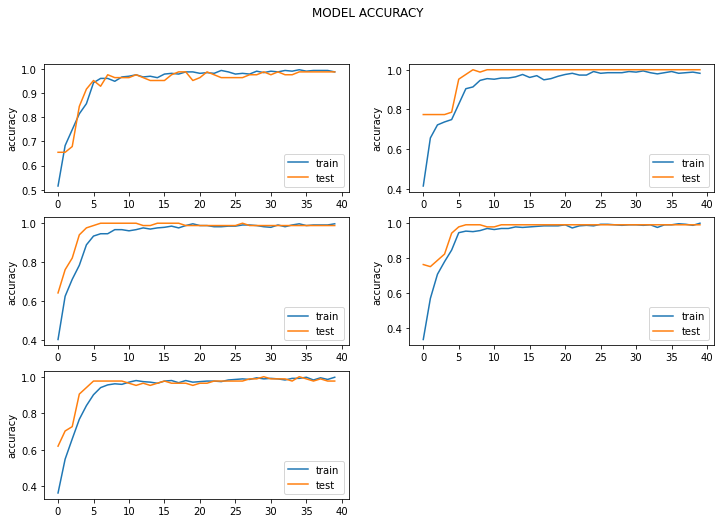

In [9]:
plt.rcParams['figure.figsize'] = [12, 8]
# model accuracy
for i in range(5):
    history = logs[i]["history"]
    plt.subplot(3, 2, i+1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.legend(['train', 'test'], loc='lower right')
plt.suptitle('MODEL ACCURACY')
plt.show()

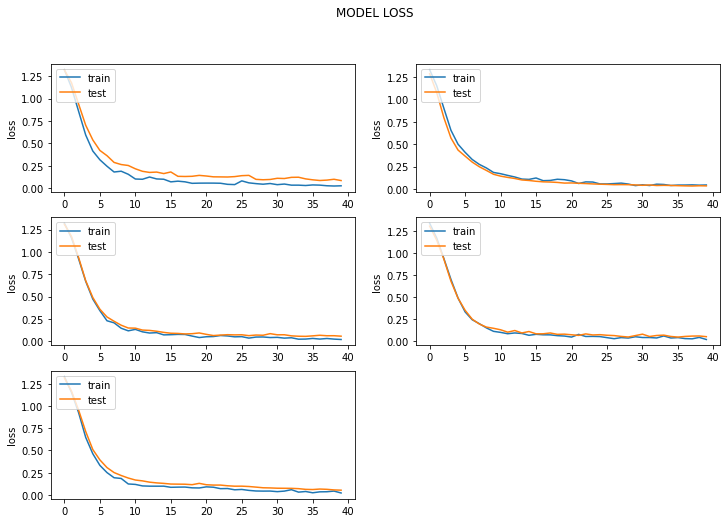

In [10]:
# model loss
for i in range(5):
    history = logs[i]["history"]
    plt.subplot(3, 2, i+1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.legend(['train', 'test'], loc='upper left')
plt.suptitle('MODEL LOSS')
plt.show()

## Model to port on Android

In [11]:
def join_events(b ,s ,a, n):
    X_combined_train = np.concatenate((b ,s ,a, n), axis=0)
    Y_combined_train = np.array([0]*len(b) + [1]*len(s) + [2]*len(a) + [3]*len(n))
    return  shuffle(X_combined_train, Y_combined_train)
    
X_train, y_test = join_events(braking ,steering ,acceleration, normal)

In [12]:
model_android = cnn_model (20,3)
model_android.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 14, 64)            1408      
                                                                 
 dropout_15 (Dropout)        (None, 14, 64)            0         
                                                                 
 conv1d_11 (Conv1D)          (None, 10, 64)            20544     
                                                                 
 dropout_16 (Dropout)        (None, 10, 64)            0         
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 128)               0         
                                                      

In [13]:
history = model_android.fit(X_train, y_test, epochs = 100, validation_split=0.2, verbose=1)

Epoch 1/100
15/15 [==============================] - 1s 12ms/step - loss: 1.2836 - accuracy: 0.4770 - val_loss: 1.2570 - val_accuracy: 0.6667
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9540 - accuracy: 0.7029 - val_loss: 0.9676 - val_accuracy: 0.7000
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6157 - accuracy: 0.7887 - val_loss: 0.6653 - val_accuracy: 0.8750
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.3943 - accuracy: 0.8766 - val_loss: 0.4761 - val_accuracy: 0.9667
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.2803 - accuracy: 0.9372 - val_loss: 0.3355 - val_accuracy: 0.9667
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.2058 - accuracy: 0.9435 - val_loss: 0.2544 - val_accuracy: 0.9833
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.1566 - accuracy: 0.9414 - val_loss: 0.2179 - val_accuracy: 0.9667
Epoch 8/100


Epoch 59/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0346 - accuracy: 0.9937 - val_loss: 0.0356 - val_accuracy: 0.9917
Epoch 60/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0099 - accuracy: 0.9979 - val_loss: 0.0905 - val_accuracy: 0.9833
Epoch 61/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0388 - accuracy: 0.9854 - val_loss: 0.0626 - val_accuracy: 0.9833
Epoch 62/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0145 - accuracy: 0.9958 - val_loss: 0.0556 - val_accuracy: 0.9833
Epoch 63/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.0587 - val_accuracy: 0.9833
Epoch 64/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.0494 - val_accuracy: 0.9833
Epoch 65/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0532 - val_accuracy: 0.9833
Epoch 

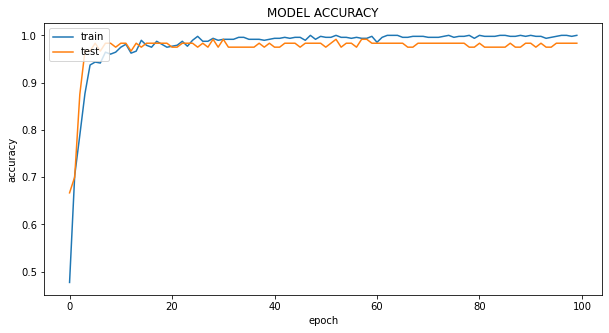

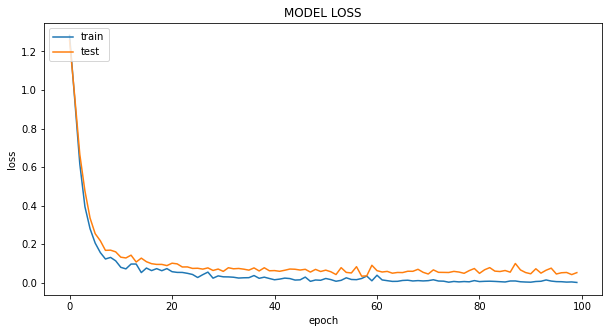

In [14]:
plt.rcParams['figure.figsize'] = [10,5]
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MODEL ACCURACY')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MODEL LOSS')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
tf.saved_model.save(model_android, "android/behaviour_recognition_model")
converter = tf.lite.TFLiteConverter.from_saved_model("android/behaviour_recognition_model")
tflite_model = converter.convert()

In [ ]:
with open('android/behaviour_model.tflite', 'wb') as f:
    f.write(tflite_model)

## Save model

In [ ]:
model_android.save('../efficiency/behaviour_model.h5')